In [52]:
import time
import matplotlib.pyplot as plt
import imageio as ig
import numpy as np
import os
from moviepy.editor import ImageSequenceClip
from PIL import Image, ImageSequence
import cv2
from demo import img_filter
import cython
from array_mp4_conversion import *
from itertools import product

In [ ]:
def img_filter(img, locations, radius=3, level=10):
    '''
    original filter, this algorithm select the most frequent intensity group in the kernel,
    and average r,b,g in the pixel group
    :param img: 3d image array height, width, channel (b,g,r)
    :param locations: list of tuple of face locations (top, right, bottom, left)
    :param radius:
    :param level:
    :return:
    '''
    des_img = np.copy(img)
    for location in locations:
        top, right, bottom, left = location
        if top+radius >= bottom-radius or left+radius>=right-radius:
            continue
        for i, j in product(range(top+radius, bottom-radius), range(left+radius, right-radius)):

            level_counter = np.zeros(level, dtype=np.uint32)
            b_level = np.zeros(level, dtype=np.uint32)
            r_level = np.zeros(level, dtype=np.uint32)
            g_level = np.zeros(level, dtype=np.uint32)

            for m, n in product(range(-radius, radius), repeat=2):
                b, g, r = img[i + m, j + n]
                avg = (b+g+r) / 3.
                pixlv = int(avg / (256 / level))
                level_counter[pixlv] += 1
                b_level[pixlv] += b
                g_level[pixlv] += g
                r_level[pixlv] += r

            most_level_Idx = np.argmax(level_counter)
            most_level_count = level_counter[most_level_Idx]

            des_img[i, j, 0] = b_level[most_level_Idx] // most_level_count
            des_img[i, j, 1] = g_level[most_level_Idx] // most_level_count
            des_img[i, j, 2] = r_level[most_level_Idx] // most_level_count

    return des_img

In [86]:
a = np.ones((3,3,3))

In [88]:
np.sum(a, axis=(0,1))

array([9., 9., 9.])

In [91]:
def mean_blur(image,locations, radius=2):
    # radius has to be even
    k = 1 / (radius*2+1)**2
    des_img = np.copy(image)
    for location in locations:
        top, right, bottom, left = location
        t_ = top+radius
        b_ = bottom-radius
        l_ = left+radius
        r_ = right-radius
        if t_ >= b_ or l_ >= r_:
            continue
        for i, j in product(range(t_, b_),range(l_, r_)):
            
            kernel = image[i-radius:i+radius+1, j-radius:j+radius+1, :]
            sumed = np.sum(kernel, axis = (0,1)) * k
            des_img[i, j] = sumed.astype(np.uint8)
    return des_img

In [100]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [110]:
%%cython
from itertools import product
import numpy as np
cimport numpy as np

ctypedef np.uint8_t D_TYPE

def mean_blur_cython(np.ndarray[D_TYPE, ndim=3] image,locations, radius=2):
    # radius has to be even
    cdef double k
    cdef int top, right, bottom, left, t_, b_, l_, r_, i, j
    cdef np.ndarray[double, ndim=1] sumed
    cdef np.ndarray[D_TYPE, ndim=3] kernel
    cdef np.ndarray[D_TYPE, ndim=3] des_img = np.copy(image)
    k = 1 / (radius*2+1)**2
    for location in locations:
        top, right, bottom, left = location
        t_ = top+radius
        b_ = bottom-radius
        l_ = left+radius
        r_ = right-radius
        if t_ >= b_ or l_ >= r_:
            continue
        for i, j in product(range(t_, b_),range(l_, r_)):
            
            kernel = image[i-radius:i+radius+1, j-radius:j+radius+1, :]
            sumed = np.sum(kernel, axis = (0,1), dtype=np.float64) * k
            des_img[i, j] = sumed.astype(np.uint8)
    return des_img

In [10]:
%load_ext Cython

In [62]:
%%cython
from itertools import product
import numpy as np
cimport numpy as np

ctypedef np.uint8_t D_TYPE


def img_filter_cython(np.ndarray[D_TYPE, ndim=3] img, locations, radius=5, level=10):
    '''
    :param img: 3d image array height, width, channel (b,g,r)
    :param locations: list of tuple of face locations (top, right, bottom, left)
    :param radius: somehow control how blurry the image is 
    :param level: intensity range
    :return: result array
    '''
    cdef int pixlv, i, j, m, n, most_level_Idx, most_level_count, top, right, bottom, left
    cdef int t_, b_, l_, r_
    cdef double avg
    cdef D_TYPE b, g, r
    cdef np.ndarray[D_TYPE, ndim=3] des_img = np.copy(img)
    cdef np.ndarray[np.uint32_t, ndim=1] level_counter
    cdef np.ndarray[np.uint32_t, ndim=1] b_level 
    cdef np.ndarray[np.uint32_t, ndim=1] r_level 
    cdef np.ndarray[np.uint32_t, ndim=1] g_level
    for location in locations:
        top, right, bottom, left = location
        t_ = top+radius
        b_ = bottom-radius
        l_ = left+radius
        r_ = right-radius
        if t_ >= b_ or l_ >= r_:
            continue
        for i, j in product(range(t_, b_),range(l_, r_)):

                level_counter = np.zeros(level, dtype=np.uint32)
                b_level = np.zeros(level, dtype=np.uint32)
                g_level = np.zeros(level, dtype=np.uint32)
                r_level = np.zeros(level, dtype=np.uint32)

                for m, n in product(range(-radius, radius), repeat=2):
                    b, g, r = img[i + m, j + n]
                    avg = (b + g + r) / 3.
                    pixlv = int(avg / (256 / level))
                    level_counter[pixlv] += 1
                    b_level[pixlv] += b
                    g_level[pixlv] += g
                    r_level[pixlv] += r

                most_level_Idx = np.argmax(level_counter)
                most_level_count = level_counter[most_level_Idx]

                des_img[i, j, 0] = b_level[most_level_Idx] // most_level_count
                des_img[i, j, 1] = g_level[most_level_Idx] // most_level_count
                des_img[i, j, 2] = r_level[most_level_Idx] // most_level_count

    return des_img

In [63]:
arr, fps = mp4_to_array("data/dance.mp4")

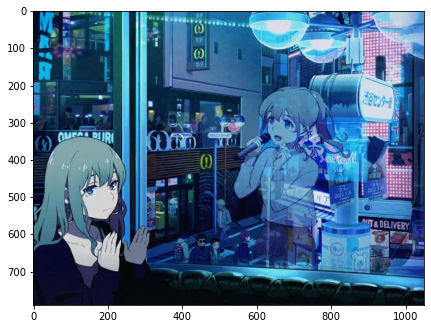

In [64]:
plt.figure(figsize=(7,10))
plt.imshow(arr[0,:,:,::-1])
plt.show()

In [84]:
start = time.time()
img = arr[0]
des_img = img_filter_cython(img, [(400,250,600,0), [200,800,400,600]], 4)
finish = time.time()
print(f"total time {finish-start}")

total time 6.7379350662231445


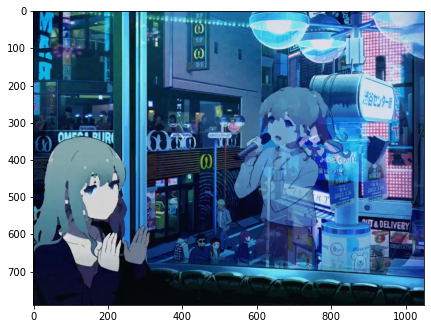

In [85]:
plt.figure(figsize=(7,10))
plt.imshow(des_img[:,:,::-1])
plt.show()

In [117]:
start = time.time()
img = arr[0]
des_img = mean_blur(img, [(400,250,600,0), (200,800,400,600)], 6)
finish = time.time()
print(f"total time {finish-start}")

total time 1.0194158554077148


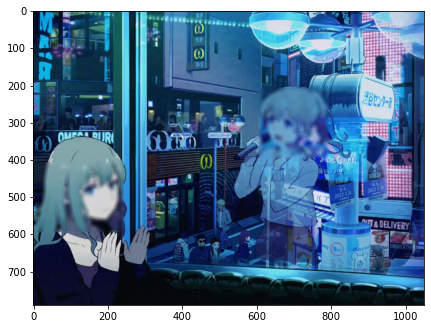

In [118]:
plt.figure(figsize=(7,10))
plt.imshow(des_img[:,:,::-1])
plt.show()

In [27]:
def gif_convert(filename, array, fps=10, scale=1.0):
    """Creates a gif given a stack of images using moviepy
    Notes
    -----
    works with current Github version of moviepy (not the pip version)
    https://github.com/Zulko/moviepy/commit/d4c9c37bc88261d8ed8b5d9b7c317d13b2cdf62e
    Usage
    -----
    >>> X = randn(100, 64, 64)
    >>> gif('test.gif', X)
    Parameters
    ----------
    filename : string
        The filename of the gif to write to
    array : array_like
        A numpy array that contains a sequence of images
    fps : int
        frames per second (default: 10)
    scale : float
        how much to rescale each image by (default: 1.0)
    """

    # ensure that the file has the .gif extension
    fname, _ = os.path.splitext(filename)
    filename = fname + '.gif'

    # copy into the color dimension if the images are black and white
    if array.ndim == 3:
        array = array[..., np.newaxis] * np.ones(3)

    # make the moviepy clip
    clip = ImageSequenceClip(list(array), fps=fps).resize(scale)
    clip.write_gif(filename, fps=fps)
    return clip

In [80]:
def oil_effect(color_img, width_range, height_range, radius=3, level=10, gap=1):
    '''
    :param color_img: 4d array of images
    :param width_range: range of width to filter
    :param height_range: range of height to filter
    :param radius: convolution radius for each pixel
    :param level: level of intensity
    :param gap: skip pixel
    :return: 2d array after oil painting effect
    '''
    page, height, weight, channel = color_img.shape
    des_img = np.copy(color_img)
    for z in range(page):
        img = color_img[z]
        for i in range(height_range[0] + radius, height_range[1] - radius, gap):
            for j in range(width_range[0] + radius, width_range[1] - radius, gap):

                # store number of each gray level of pixel

                level_counter = np.zeros(level)
                b_level = np.zeros(level)
                r_level = np.zeros(level)
                g_level = np.zeros(level)

                for m in range(-radius, radius):
                    for n in range(-radius, radius):
                        b, g, r = img[i+m, j+n]
                        avg = (b+g+r) / 3.
                        pixlv = int(avg / (256 / level))
                        level_counter[pixlv] += 1
                        b_level[pixlv] += b
                        g_level[pixlv] += g
                        r_level[pixlv] += r

                most_level_count = np.max(level_counter)
                most_level_Idx = np.argmax(level_counter)

                des_img[z, i, j, 0] = b_level[most_level_Idx] // most_level_count
                des_img[z, i, j, 1] = g_level[most_level_Idx] // most_level_count
                des_img[z, i, j, 2] = r_level[most_level_Idx] // most_level_count

    return des_img